In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import torch
import os
import random

%matplotlib inline
from matplotlib import pyplot as plt

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [129]:
def train_model(model, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=500):
    X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
    X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)
    train_accuracy = []
    test_accuracy = []
    train_batch_size = len(X_train_lengths)
    for i in range(epochs):
        params = list(model.named_parameters())
        model.zero_grad()
        hidden = model.init_hidden(train_batch_size).float()
        output = model(X_train_padded, hidden, X_train_lengths)
        loss = F.cross_entropy(output, Y_train)
        loss.backward()
        optimizer.step()
        for param_name, param in params:
            print(param_name, np.linalg.norm(param.grad.to("cpu").numpy()))
        optimizer.zero_grad()
        tr_accuracy = test_model(model, X_train, X_train_lengths, Y_train)
        train_accuracy.append(tr_accuracy)
        tst_accuracy = test_model(model, X_test, X_test_lengths, Y_test)
        test_accuracy.append(tst_accuracy)
    
    return model.eval(), train_accuracy, test_accuracy

In [62]:
def test_model(model, X_samp, X_samp_lengths, Y_samp):
    batch_size = len(X_samp_lengths)
    hidden = model.init_hidden(batch_size).float()
    X_samp_padded = torch.nn.utils.rnn.pad_sequence(X_samp, batch_first=True)
    output_test = model(X_samp_padded, hidden, X_samp_lengths)
    total = 0
    correct = 0
    for i, out_t in enumerate(output_test):
        if int(torch.argmax(out_t)) - int(Y_samp[i]) == 0:
            correct = correct + 1
        total = total + 1

    return (correct/total)

In [4]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

filenames = os.listdir("./datasets/names")
names_data = {}

for filename in filenames:
    f = open(f"./datasets/names/{filename}")
    data = f.read()
    names = list(filter(lambda l: len(l) > 0, map(lambda n: unicode_to_ascii(n.strip()).lower().strip(','), data.split("\n"))))
    names_data[filename.strip(".txt").lower()] = names
    f.close()

languages = list(names_data.keys())
languages.sort()


def one_hot_code(name):
    line_vector = []
    for c in name:
        letter_vector = [0] * 28
        i = ord(c) - 97
        if i == ord(" ") - 97:
            letter_vector[26] = 1
        elif i == ord("'") - 97:
            letter_vector[27] = 1
        else:
            letter_vector[i] = 1

        line_vector.append(letter_vector)
    
    return line_vector


def one_hot_to_word(name_vec):
    name = ""
    for letter_vec in name_vec:
        num = np.argmax(letter_vec)
        if num == 26:
            name = name + " "
        elif num == 27:
            name = name + "'"
        else:
            name = name + chr(num + 97)
    
    return name


def label_to_vec(lang):
    label_vec = [0] * len(languages)
    i = languages.index(lang)
    label_vec[i] = 1
    
    return label_vec


def vec_to_label(label_vec):
    i = np.argmax(np.array(label_vec))
    return languages[i]


X_tr = []
X_tst = []
Y_tr = []
Y_tst = []

for lang in languages:
    label_vec = label_to_vec(lang)
    lang_names = names_data[lang]
    random.shuffle(lang_names)
    for name in lang_names[:int(0.8 * len(lang_names))]:
        name_vec = one_hot_code(name)
        X_tr.append(name_vec)
        Y_tr.append(label_vec)
    for name in lang_names[int(0.8 * len(lang_names)):]:
        name_vec = one_hot_code(name)
        X_tst.append(name_vec)
        Y_tst.append(label_vec)

train_indices = list(range(len(X_tr)))
test_indices = list(range(len(X_tst)))
random.shuffle(train_indices)
random.shuffle(test_indices)
X_train = list(map(lambda i: X_tr[i], train_indices))
Y_train = list(map(lambda i: Y_tr[i], train_indices))
X_test = list(map(lambda i: X_tst[i], test_indices))
Y_test = list(map(lambda i: Y_tst[i], test_indices))

In [5]:
one_hot_to_word(X_train[3]), vec_to_label(Y_train[3])

('avdulov', 'russian')

In [6]:
len(languages)

18

In [7]:
train_set = list(zip(X_train, Y_train))

In [8]:
train_set = sorted(train_set, key=lambda t: len(t[0]), reverse=True)

In [9]:
test_set = list(zip(X_test, Y_test))

In [10]:
test_set = sorted(test_set, key=lambda t: len(t[0]), reverse=True)

In [11]:
X_train = []
X_train_lengths = []
Y_train = []
X_test = []
X_test_lengths = []
Y_test = []
for x, y in train_set:
    X_train.append(torch.tensor(x).float().to(device))
    X_train_lengths.append(len(x))
    Y_train.append(np.argmax(torch.tensor(y)))

Y_train = torch.tensor(Y_train).to(device)

for x, y in test_set:
    X_test.append(torch.tensor(x).float().to(device))
    X_test_lengths.append(len(x))
    Y_test.append(np.argmax(torch.tensor(y)))

Y_test = torch.tensor(Y_test).to(device)

In [12]:
X_train_padded = torch.nn.utils.rnn.pad_sequence(X_train, batch_first=True)
X_test_padded = torch.nn.utils.rnn.pad_sequence(X_test, batch_first=True)

In [13]:
X_train_padded_packed = torch.nn.utils.rnn.pack_padded_sequence(X_train_padded, X_train_lengths, batch_first=True)

In [14]:
X_train_padded_packed

PackedSequence(data=tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'), batch_sizes=tensor([16053, 16053, 16012, 15738, 14728, 12565,  9436,  6470,  3995,  2165,
          988,   420,   165,    71,    36,    23,    18,     2,     1]), sorted_indices=None, unsorted_indices=None)

In [130]:
class ModelOne(nn.Module):
    
    def __init__(self):
        super(ModelOne, self).__init__()
        self.rnn = nn.RNN(28, 128, 4, nonlinearity="relu", dropout=0.25, batch_first=True)
        self.dense = nn.Linear(128, 18)
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(4, batch_size, 128).to(device)

        return hidden
    
    def forward(self, x, hidden, x_lengths):
        batch_size = x.size(0)
        max_sequence_size = x.size(1)
        # hidden = self.init_hidden(batch_size).float()
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lengths, batch_first=True)
        out, hidden = self.rnn(x, hidden)
        out, _ = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first=True)
        out = out.contiguous()
        out = out.view(-1, 128)
        out = self.dense(out)
        out = out.view(batch_size, max_sequence_size, 18)
        
        indexes = torch.tensor(x_lengths) - 1
        out = out[torch.arange(batch_size), indexes, :]
        
        return F.softmax(out, dim=1)

In [131]:
model_one = ModelOne().to(device)

In [364]:
output = model_one(X_train_padded, X_train_lengths)

In [365]:
len(output)

16053

In [366]:
output.size()

torch.Size([16053, 18])

In [367]:
output[0]

tensor([0.0553, 0.0519, 0.0628, 0.0535, 0.0580, 0.0517, 0.0587, 0.0560, 0.0576,
        0.0484, 0.0504, 0.0604, 0.0506, 0.0488, 0.0542, 0.0706, 0.0546, 0.0567],
       grad_fn=<SelectBackward>)

In [18]:
one_hot_to_word(X_train[0]), languages[int(Y_train[0])]

('shirinskyshikhmatov', 'russian')

In [132]:
optimizer = optim.Adam(model_one.parameters(), lr=0.001)
model_one, train_accuracy, test_accuracy = train_model(model_one, optimizer, X_train, X_train_lengths, Y_train, X_test, X_test_lengths, Y_test, epochs=100)

rnn.weight_ih_l0 0.00028916093
rnn.weight_hh_l0 0.00039104122
rnn.bias_ih_l0 0.0005730381
rnn.bias_hh_l0 0.0005730381
rnn.weight_ih_l1 0.0011867032
rnn.weight_hh_l1 0.0011301237
rnn.bias_ih_l1 0.0017027869
rnn.bias_hh_l1 0.0017027869
rnn.weight_ih_l2 0.0029960652
rnn.weight_hh_l2 0.003332967
rnn.bias_ih_l2 0.0044431416
rnn.bias_hh_l2 0.0044431416
rnn.weight_ih_l3 0.008227309
rnn.weight_hh_l3 0.00776236
rnn.bias_ih_l3 0.010993254
rnn.bias_hh_l3 0.010993254
dense.weight 0.018748816
dense.bias 0.026552053
rnn.weight_ih_l0 0.00033694055
rnn.weight_hh_l0 0.0005620742
rnn.bias_ih_l0 0.00082962087
rnn.bias_hh_l0 0.00082962087
rnn.weight_ih_l1 0.0015672934
rnn.weight_hh_l1 0.0015767119
rnn.bias_ih_l1 0.0022777184
rnn.bias_hh_l1 0.0022777184
rnn.weight_ih_l2 0.0036627185
rnn.weight_hh_l2 0.0040631327
rnn.bias_ih_l2 0.0052263467
rnn.bias_hh_l2 0.0052263467
rnn.weight_ih_l3 0.008966604
rnn.weight_hh_l3 0.008477808
rnn.bias_ih_l3 0.0115592275
rnn.bias_hh_l3 0.0115592275
dense.weight 0.020456247
de

rnn.weight_ih_l0 5.2630196e-05
rnn.weight_hh_l0 2.1783713e-05
rnn.bias_ih_l0 0.00010783838
rnn.bias_hh_l0 0.00010783838
rnn.weight_ih_l1 0.00010136517
rnn.weight_hh_l1 3.2403346e-05
rnn.bias_ih_l1 8.785389e-05
rnn.bias_hh_l1 8.785389e-05
rnn.weight_ih_l2 0.00012315548
rnn.weight_hh_l2 3.9232204e-05
rnn.bias_ih_l2 6.0715756e-05
rnn.bias_hh_l2 6.0715756e-05
rnn.weight_ih_l3 0.000168871
rnn.weight_hh_l3 5.2157855e-05
rnn.bias_ih_l3 3.9350303e-05
rnn.bias_hh_l3 3.9350303e-05
dense.weight 0.00045856833
dense.bias 5.549929e-05
rnn.weight_ih_l0 5.20051e-05
rnn.weight_hh_l0 2.3269033e-05
rnn.bias_ih_l0 0.00012000432
rnn.bias_hh_l0 0.00012000432
rnn.weight_ih_l1 0.00011846182
rnn.weight_hh_l1 3.5590503e-05
rnn.bias_ih_l1 9.705532e-05
rnn.bias_hh_l1 9.705532e-05
rnn.weight_ih_l2 0.00013375859
rnn.weight_hh_l2 4.4827902e-05
rnn.bias_ih_l2 6.47724e-05
rnn.bias_hh_l2 6.47724e-05
rnn.weight_ih_l3 0.00017608177
rnn.weight_hh_l3 6.154296e-05
rnn.bias_ih_l3 4.192855e-05
rnn.bias_hh_l3 4.192855e-05
dens

rnn.weight_ih_l0 4.0815685e-06
rnn.weight_hh_l0 1.0860454e-06
rnn.bias_ih_l0 5.6463246e-06
rnn.bias_hh_l0 5.6463246e-06
rnn.weight_ih_l1 5.804172e-06
rnn.weight_hh_l1 1.3322152e-06
rnn.bias_ih_l1 3.525099e-06
rnn.bias_hh_l1 3.525099e-06
rnn.weight_ih_l2 6.024084e-06
rnn.weight_hh_l2 1.6607656e-06
rnn.bias_ih_l2 1.7852757e-06
rnn.bias_hh_l2 1.7852757e-06
rnn.weight_ih_l3 7.2328194e-06
rnn.weight_hh_l3 2.2751149e-06
rnn.bias_ih_l3 9.2555206e-07
rnn.bias_hh_l3 9.2555206e-07
dense.weight 2.1657497e-05
dense.bias 1.0890067e-06
rnn.weight_ih_l0 3.7929194e-06
rnn.weight_hh_l0 9.931732e-07
rnn.bias_ih_l0 5.318763e-06
rnn.bias_hh_l0 5.318763e-06
rnn.weight_ih_l1 5.3856566e-06
rnn.weight_hh_l1 1.2397843e-06
rnn.bias_ih_l1 3.1803097e-06
rnn.bias_hh_l1 3.1803097e-06
rnn.weight_ih_l2 8.8170145e-06
rnn.weight_hh_l2 1.5111856e-06
rnn.bias_ih_l2 1.6223415e-06
rnn.bias_hh_l2 1.6223415e-06
rnn.weight_ih_l3 6.8617173e-06
rnn.weight_hh_l3 2.1618096e-06
rnn.bias_ih_l3 8.839126e-07
rnn.bias_hh_l3 8.839126e-

rnn.weight_ih_l0 1.3791835e-06
rnn.weight_hh_l0 4.2427777e-07
rnn.bias_ih_l0 2.5471202e-06
rnn.bias_hh_l0 2.5471202e-06
rnn.weight_ih_l1 2.3798418e-06
rnn.weight_hh_l1 5.4586883e-07
rnn.bias_ih_l1 1.5393067e-06
rnn.bias_hh_l1 1.5393067e-06
rnn.weight_ih_l2 2.5514455e-06
rnn.weight_hh_l2 6.641789e-07
rnn.bias_ih_l2 7.953896e-07
rnn.bias_hh_l2 7.953896e-07
rnn.weight_ih_l3 3.3455185e-06
rnn.weight_hh_l3 1.1176901e-06
rnn.bias_ih_l3 4.3102176e-07
rnn.bias_hh_l3 4.3102176e-07
dense.weight 1.0788312e-05
dense.bias 5.010326e-07
rnn.weight_ih_l0 1.1907765e-06
rnn.weight_hh_l0 3.8801397e-07
rnn.bias_ih_l0 2.2729512e-06
rnn.bias_hh_l0 2.2729512e-06
rnn.weight_ih_l1 2.161137e-06
rnn.weight_hh_l1 4.9336484e-07
rnn.bias_ih_l1 1.3629046e-06
rnn.bias_hh_l1 1.3629046e-06
rnn.weight_ih_l2 2.2414206e-06
rnn.weight_hh_l2 5.8768325e-07
rnn.bias_ih_l2 6.8877114e-07
rnn.bias_hh_l2 6.8877114e-07
rnn.weight_ih_l3 2.9934831e-06
rnn.weight_hh_l3 9.90997e-07
rnn.bias_ih_l3 3.7055148e-07
rnn.bias_hh_l3 3.7055148

rnn.weight_ih_l0 1.1072916e-06
rnn.weight_hh_l0 3.7902078e-07
rnn.bias_ih_l0 2.255191e-06
rnn.bias_hh_l0 2.255191e-06
rnn.weight_ih_l1 2.2427917e-06
rnn.weight_hh_l1 4.843273e-07
rnn.bias_ih_l1 1.4115999e-06
rnn.bias_hh_l1 1.4115999e-06
rnn.weight_ih_l2 3.8335215e-06
rnn.weight_hh_l2 6.1916984e-07
rnn.bias_ih_l2 6.9917536e-07
rnn.bias_hh_l2 6.9917536e-07
rnn.weight_ih_l3 3.2012258e-06
rnn.weight_hh_l3 1.0620771e-06
rnn.bias_ih_l3 3.9311487e-07
rnn.bias_hh_l3 3.9311487e-07
dense.weight 1.0223003e-05
dense.bias 4.583439e-07
rnn.weight_ih_l0 1.5231298e-06
rnn.weight_hh_l0 4.0589222e-07
rnn.bias_ih_l0 2.2450472e-06
rnn.bias_hh_l0 2.2450472e-06
rnn.weight_ih_l1 2.1918127e-06
rnn.weight_hh_l1 4.8714475e-07
rnn.bias_ih_l1 1.3003303e-06
rnn.bias_hh_l1 1.3003303e-06
rnn.weight_ih_l2 3.826272e-06
rnn.weight_hh_l2 6.029073e-07
rnn.bias_ih_l2 6.3457105e-07
rnn.bias_hh_l2 6.3457105e-07
rnn.weight_ih_l3 3.2686728e-06
rnn.weight_hh_l3 9.600569e-07
rnn.bias_ih_l3 3.5831903e-07
rnn.bias_hh_l3 3.5831903

rnn.weight_ih_l0 2.3650239e-06
rnn.weight_hh_l0 6.595763e-07
rnn.bias_ih_l0 3.7339653e-06
rnn.bias_hh_l0 3.7339653e-06
rnn.weight_ih_l1 3.703681e-06
rnn.weight_hh_l1 8.0287367e-07
rnn.bias_ih_l1 2.2311378e-06
rnn.bias_hh_l1 2.2311378e-06
rnn.weight_ih_l2 3.6933836e-06
rnn.weight_hh_l2 1.0439138e-06
rnn.bias_ih_l2 1.0842192e-06
rnn.bias_hh_l2 1.0842192e-06
rnn.weight_ih_l3 6.198509e-06
rnn.weight_hh_l3 2.0542984e-06
rnn.bias_ih_l3 7.014014e-07
rnn.bias_hh_l3 7.014014e-07
dense.weight 1.9940211e-05
dense.bias 8.289195e-07
rnn.weight_ih_l0 2.6108153e-06
rnn.weight_hh_l0 8.125422e-07
rnn.bias_ih_l0 5.084085e-06
rnn.bias_hh_l0 5.084085e-06
rnn.weight_ih_l1 4.932136e-06
rnn.weight_hh_l1 1.0604563e-06
rnn.bias_ih_l1 2.985216e-06
rnn.bias_hh_l1 2.985216e-06
rnn.weight_ih_l2 8.974987e-06
rnn.weight_hh_l2 1.4723222e-06
rnn.bias_ih_l2 1.5888174e-06
rnn.bias_hh_l2 1.5888174e-06
rnn.weight_ih_l3 8.584961e-06
rnn.weight_hh_l3 2.9958212e-06
rnn.bias_ih_l3 1.0210429e-06
rnn.bias_hh_l3 1.0210429e-06
de

rnn.weight_ih_l0 2.8764169e-05
rnn.weight_hh_l0 7.4529744e-06
rnn.bias_ih_l0 4.2599684e-05
rnn.bias_hh_l0 4.2599684e-05
rnn.weight_ih_l1 4.2230207e-05
rnn.weight_hh_l1 1.0659274e-05
rnn.bias_ih_l1 2.4636578e-05
rnn.bias_hh_l1 2.4636578e-05
rnn.weight_ih_l2 5.6028195e-05
rnn.weight_hh_l2 1.9969182e-05
rnn.bias_ih_l2 1.4556743e-05
rnn.bias_hh_l2 1.4556743e-05
rnn.weight_ih_l3 0.0001513291
rnn.weight_hh_l3 5.4312273e-05
rnn.bias_ih_l3 1.6355429e-05
rnn.bias_hh_l3 1.6355429e-05
dense.weight 0.00047729514
dense.bias 1.8383744e-05
rnn.weight_ih_l0 4.0028353e-05
rnn.weight_hh_l0 1.08005e-05
rnn.bias_ih_l0 6.2714615e-05
rnn.bias_hh_l0 6.2714615e-05
rnn.weight_ih_l1 6.248829e-05
rnn.weight_hh_l1 1.6448897e-05
rnn.bias_ih_l1 3.792118e-05
rnn.bias_hh_l1 3.792118e-05
rnn.weight_ih_l2 9.211052e-05
rnn.weight_hh_l2 3.347343e-05
rnn.bias_ih_l2 2.4257417e-05
rnn.bias_hh_l2 2.4257417e-05
rnn.weight_ih_l3 0.00026972915
rnn.weight_hh_l3 9.731932e-05
rnn.bias_ih_l3 2.9407813e-05
rnn.bias_hh_l3 2.9407813e-

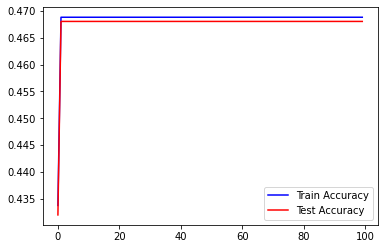

In [133]:
fig, ax = plt.subplots()
ax.plot(train_accuracy, "b-", label="Train Accuracy")
ax.plot(test_accuracy, "r-", label="Test Accuracy")
leg = ax.legend()